# Exploration 10. CIFAR-10 활용하여 새로운 이미지 만들기

- 목표: CIFAR-10 데이터를 사용해서 DCGAN을 훈련시켜서 이미지를 생성한다.

--------------------------
## 목차
### 0. GAN 구성
### 1. 모델에 만들기에 필요한 함수들
    1-1. 생성자(Generator) 만들기   
    1-2. 판별자(Discriminator)만들기   
    1-3. loss & accuracy 만들기   
    1-4. 1 step 동안의 학습 설계   
    1-5. 학습과정 시각화 함수   
    1-6. 모델 전체학습
    1-7. 기타 함수

### 2. 데이터 전처리 및 시각화
    2-1. 데이터 전처리
    2-2. CIFAR-10 훈련데이터 시각화

### 3. 모델 학습하기
    3-1.  기본 모델(try1) 및 개선방안
        - 모델 개선방안
    3-2. 개선시킨 모델 : (try2)
    3-3. 개선모델(try2)+ latent 벡터의 랜덤 값을 -1 ~ 1 사이로 조정: (try3)
    3-4. 개선모델(try2)에서 Batch Normalize를 빼보자 (try4)
    3-5. 개와 고양이 이미지만 모아서 개선된 GAN 모델(try2)을 돌려보자! :(try5)
    3-6. 새와 비행기 이미지만 모아서 개선된 GAN 모델(try2)을 돌려보자!: (try6)
    3-7. 개선된 모델의 생성자에 batch normalization 제거하고, conv 3층 : (try7)
    3-8. 개선모델(try2)의 판별자를 sigmoid가 없는 것으로 바꿈: (try8)
    
### 4. 관찰
    4-1. 모델 구조의 차이
    4-2. 모델의 데이터의 차이
    4-3. latent vector를 -1~1사이로 두었을때 생성되는 이미지
    
### 5. 회고
----------------------

## 0. GAN 구성
![GAN 전체구조](https://editor.analyticsvidhya.com/uploads/754471a.png)

- 크기가 100인 Random input(latent 벡터, 노이즈라고도 함)을 seed로 생성자(Generator)가 fake image(sample)을 생성하면, 판별자(Discriminator)가  학습데이터인 Real image(sample)와 fake image(sample)을 분류해낸다. 
- 흔히 GAN의 생성자와 판별자를 위조지폐범과 경찰에 비교를 많이 한다. 위조지폐범(생성자, Generator)이 위조지폐를 열심히 만들어내면, 경찰(Discriminator)가 열심히 위조지폐인지 진짜 지폐인지 구분해내고 이 둘은 서로 경쟁을 하면서 위조지폐범은 처음에는 어설픈 지폐를 만들었을지라도 경찰에게 들키지 않기 위해서 더 정교하게 지폐를 만들고 경찰은 지폐를 더 잘 분류해내게 된다.

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0




## 1. 모델에 만들기에 필요한 함수들

### 1-1. 생성자(generator) 만들기 
제너레이터를 __구조적__ 으로는 __1. Batch Normalization의 유무, 2. convolution 레이어 3층 & 4층__ 을 만들려고 한다.    

- make_generator_model_ver1: Batch Normalization이 있고, convolution 레이어가 4층   
- make_generator_model_ver2: Batch Normalization이 없고, convolution 레이어가 4층   
- make_generator_model_ver3: Batch Normalization이 있고, convolution 레이어가 3층   
- make_generator_model_ver4: Batch Normalization이 없고, convolution 레이어가 3층   
  

In [3]:
# Batch Normalization을 포함 & convolution 4층인 제너레이터
def make_generator_model_ver1(filter_num=512,Leaky_alpha=0.3,kernel_size=5):

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*filter_num, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=Leaky_alpha))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, filter_num)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(int(filter_num/2), kernel_size=(kernel_size, kernel_size), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=Leaky_alpha))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(int(filter_num/4), kernel_size=(kernel_size, kernel_size), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=Leaky_alpha))

    model.add(layers.Conv2DTranspose(int(filter_num/8), kernel_size=(kernel_size, kernel_size), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=Leaky_alpha))

    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(kernel_size, kernel_size), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

# Batch Normalization 없고 & convolution 4층인 제너레이터
def make_generator_model_ver2(filter_num=512,Leaky_alpha=0.3, kernel_size=5):

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*filter_num, use_bias=False, input_shape=(100,)))
    model.add(layers.LeakyReLU(alpha=Leaky_alpha))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, filter_num)))

    # Third: Conv2DTranspose layer 
    model.add(layers.Conv2DTranspose(int(filter_num/2), kernel_size=(kernel_size, kernel_size), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.LeakyReLU(alpha=Leaky_alpha))

    # Fourth: Conv2DTranspose layer 
    model.add(layers.Conv2DTranspose(int(filter_num/4), kernel_size=(kernel_size, kernel_size), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.LeakyReLU(alpha=Leaky_alpha))

    model.add(layers.Conv2DTranspose(int(filter_num/8), kernel_size=(kernel_size, kernel_size), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.LeakyReLU(alpha=Leaky_alpha))

    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(kernel_size, kernel_size), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

# Batch Normalization을 포함 & convolution 3층인 제너레이터
def make_generator_model_ver3(filter_num=256,Leaky_alpha=0.3,kernel_size=5):

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*filter_num, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=Leaky_alpha))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, filter_num)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(int(filter_num/2), kernel_size=(kernel_size, kernel_size), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=Leaky_alpha))

    model.add(layers.Conv2DTranspose(int(filter_num/4), kernel_size=(kernel_size, kernel_size), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=Leaky_alpha))

    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(kernel_size, kernel_size), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

# Batch Normalization 없고 & convolution 4층인 제너레이터
def make_generator_model_ver4(filter_num=256,Leaky_alpha=0.3,kernel_size=5):

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*filter_num, use_bias=False, input_shape=(100,)))
    model.add(layers.LeakyReLU(alpha=Leaky_alpha))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, filter_num)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(int(filter_num/2), kernel_size=(kernel_size, kernel_size), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.LeakyReLU(alpha=Leaky_alpha))

    model.add(layers.Conv2DTranspose(int(filter_num/4), kernel_size=(kernel_size, kernel_size), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.LeakyReLU(alpha=Leaky_alpha))

    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(kernel_size, kernel_size), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

### 1-2. 판별자(discriminator) 만들기
- make_discriminator_model_ver1: sigmoid를 포함하지않고, CNN 레이어마다 Dropout하는 판별자   
- make_discriminator_model_ver2: sigmoid를 포함하고, 마지막 Flatten레이어 이후에 dropout을 하는 판별자   

In [4]:
def make_discriminator_model_ver1(filter_num=512,Leaky_alpha=0.2):

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer/downsample
    model.add(layers.Conv2D(int(filter_num/8), (3, 3), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=Leaky_alpha))
    model.add(layers.Dropout(0.3))
    
    # Second: Conv2D Layer/downsample
    model.add(layers.Conv2D(int(filter_num/4), (3, 3), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=Leaky_alpha))
    model.add(layers.Dropout(0.3))

    # Third: Conv2D Layer/downsample
    model.add(layers.Conv2D(int(filter_num/2), (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=Leaky_alpha))
    model.add(layers.Dropout(0.3))

    # Fourth: Flatten Layer
    model.add(layers.Flatten())

    # Fifth: Dense Layer
    model.add(layers.Dense(1))

    return model


def make_discriminator_model_ver2(filter_num=512,Leaky_alpha=0.2):

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer/downsample
    model.add(layers.Conv2D(int(filter_num/8), (3, 3), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=Leaky_alpha))

    # Second: Conv2D Layer/downsample
    model.add(layers.Conv2D(int(filter_num/4), (3, 3), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=Leaky_alpha))

    # Third:  Conv2D Layer/downsample
    model.add(layers.Conv2D(int(filter_num/2), (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=Leaky_alpha))

    # Fourth: classifier
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation="sigmoid"))

    return model

크기가 100인 latent vector(랜덤한 숫자로 이뤄진 벡터)를 입력하면 __생성자(generator)가 한장의 이미지(1,32,32,3)를 생성__ 하는지 그리고 __판별자가 fake이미지인지 real 이미지인지 하나의 숫자로 출력__ 해내는지 확인해보자. 아직 학습이 안되었기 때문에 출력을 잘하는지 모양만 볼것이다.

In [5]:
generators = [make_generator_model_ver1(),
              make_generator_model_ver2(),
              make_generator_model_ver3(),
              make_generator_model_ver4()]
discriminators=[make_discriminator_model_ver1(), make_discriminator_model_ver2()]
name_of_generators=["make_generator_model_ver%d"%i for i in range(1,5)]
name_of_discriminators=["make_discriminator_model_ver%d"%i for i in range(1,3)]

noise = tf.random.normal([1, 100])

for gen,j in zip(generators,name_of_generators):
    generated_image = gen(noise, training=False)
    print("generator로 만들어진 이미지 크기:",generated_image.shape)
    for disc,i in zip(discriminators, name_of_discriminators):
        decision = disc(generated_image, training=False)
        print(i,"&",j,"/",decision)
        print("---"*20)
    print("========"*10)

generator로 만들어진 이미지 크기: (1, 32, 32, 3)
make_discriminator_model_ver1 & make_generator_model_ver1 / tf.Tensor([[0.0010482]], shape=(1, 1), dtype=float32)
------------------------------------------------------------
make_discriminator_model_ver2 & make_generator_model_ver1 / tf.Tensor([[0.50038195]], shape=(1, 1), dtype=float32)
------------------------------------------------------------
generator로 만들어진 이미지 크기: (1, 32, 32, 3)
make_discriminator_model_ver1 & make_generator_model_ver2 / tf.Tensor([[0.00054546]], shape=(1, 1), dtype=float32)
------------------------------------------------------------
make_discriminator_model_ver2 & make_generator_model_ver2 / tf.Tensor([[0.5002357]], shape=(1, 1), dtype=float32)
------------------------------------------------------------
generator로 만들어진 이미지 크기: (1, 32, 32, 3)
make_discriminator_model_ver1 & make_generator_model_ver3 / tf.Tensor([[0.00105364]], shape=(1, 1), dtype=float32)
------------------------------------------------------------
make_

원하는 출력의 shape를 출력하는 것을 확인할수 있다.   
__make_discriminator_model_ver1__ 은 0.001이거나 미만인 값을 갖는데 비해, __판별자 make_discriminator_model_ver2__ 의 경우 __마지막 레이어에 sigmoid를 추가__ 해서 그런지 0.5부근의 값이 나오는 것을 확인 할수 있었다.

### 1-3. loss function과 accuracy 함수
- make_discriminator_model_ver1의 loss와 accuray

In [6]:
cross_entropy_ver1 = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss_ver1(fake_output):
    return cross_entropy_ver1(tf.ones_like(fake_output), fake_output)

def discriminator_loss_ver1(real_output, fake_output):
    real_loss = cross_entropy_ver1(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy_ver1(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def discriminator_accuracy_ver1(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

- make_discriminator_model_ver2의 loss와 accuray: __판별자 모델의 두번째 버전(ver.2)의 마지막 레이어에 sigmoid 함수를 썼기 때문에 BinaryCrossentropy의 from_logits=True__ 설정을 넣어주면 안된다.

In [7]:
cross_entropy_ver2 = tf.keras.losses.BinaryCrossentropy()

def generator_loss_ver2(fake_output):
    return cross_entropy_ver2(tf.ones_like(fake_output), fake_output)

def discriminator_loss_ver2(real_output, fake_output):
    real_loss = cross_entropy_ver2(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy_ver2(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def discriminator_accuracy_ver2(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### 1-4. 학습 설계(1 step)


In [25]:
@tf.function
def train_step_ver1(images):  #(1) 입력데이터
    noise_dim=100
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈/ 자동미분시작
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss_ver1(fake_output)
        disc_loss = discriminator_loss_ver1(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy_ver1(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

@tf.function
def train_step_ver2(images):  #(1) 입력데이터
    noise_dim=100
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss_ver2(fake_output)
        disc_loss = discriminator_loss_ver2(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy_ver2(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

### 1-5. 학습과정 시각화 함수


In [9]:
# generator가 만든 이미지를 시각화하고, 저장하는 함수
def generate_and_save_images(model, epoch, it, sample_seeds, try_, gener_ver, disc_ver1):
    if disc_ver1==True:
        disc_ver=1
    else:disc_ver=2

    predictions = model(sample_seeds, training=False) # generator 모델이 만들어낸 이미지

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1) # subplot으로 만든다.
        plt.imshow(clipping_img(predictions[i, :, :, :])) # 이미지를 시각화하기 위해서 잠시 0,1사이로 바꿔준다.
        plt.axis('off')
    fig.suptitle('try:%d/generator model: ver%d/ discriminator model: ver%d/epoch: %d/ iter: %d'%(try_, gener_ver, disc_ver,epoch, it),
                ha="left",fontsize=10)
   # 이미지 저장
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/try{}/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), try_,epoch, it))

    plt.show()

In [10]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.
def draw_train_history(history, epoch, try_, gener_ver, disc_ver1):
    if disc_ver1==True:
        disc_ver=1
    else:disc_ver=2
    
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss      /try:%d/generator model: ver%d/ discriminator model: ver%d/epoch: %d'%(try_,gener_ver, disc_ver,epoch))  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  
    plt.grid()

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'], linewidth=0.2)  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    plt.grid()
    
    plt.tight_layout()
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/try{}/training_history/train_history_{:04d}.png'.format(os.getenv('HOME'),try_,epoch))
    
    plt.show()

### 1-6. 모델 학습

In [26]:
def train(dataset, epochs, save_every, try_,
          gener_ver,gener_filter_num,gener_leaky_alpha,gener_kernel_size, # generator의 하이퍼파라미터
          disc_ver1, disc_filter_num, disc_leaky_alpha):  # discriminator의 하이퍼파라미터

    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            if disc_ver1:
                gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step_ver1(image_batch)  # discriminator의 하이퍼파라미터
            else:
                gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step_ver2(image_batch)  # discriminator의 하이퍼파라미터

            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True) # 셀의 화면 output을 지운다.
                generate_and_save_images(generator, epoch+1, it+1, seed, try_, gener_ver, disc_ver1)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed, try_, gener_ver, disc_ver1)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch, try_,gener_ver, disc_ver1)
    return history

### 1-7. 기타 함수

In [12]:
def select_model_ver(gener_ver, disc_ver1,gener_filter_num,gener_leaky_alpha,gener_kernel_size,
                    disc_filter_num, disc_leaky_alpha):
    if gener_ver==1:
        generator=make_generator_model_ver1(filter_num=gener_filter_num, Leaky_alpha=gener_leaky_alpha, kernel_size=gener_kernel_size)
    elif gener_ver==2:
        generator=make_generator_model_ver2(filter_num=gener_filter_num, Leaky_alpha=gener_leaky_alpha, kernel_size=gener_kernel_size)
    elif gener_ver==3:
        generator=make_generator_model_ver3(filter_num=gener_filter_num, Leaky_alpha=gener_leaky_alpha, kernel_size=gener_kernel_size)
    elif gener_ver==4:
        generator=make_generator_model_ver4(filter_num=gener_filter_num, Leaky_alpha=gener_leaky_alpha, kernel_size=gener_kernel_size)
    else:
        print("gener_ver:잘못된 입력값입니다.")

    if disc_ver1:
        discriminator=make_discriminator_model_ver1(filter_num=disc_filter_num, Leaky_alpha=disc_leaky_alpha)
    else:
        discriminator=make_discriminator_model_ver2(filter_num=disc_filter_num, Leaky_alpha=disc_leaky_alpha)
    return generator, discriminator

In [2]:
def make_folder(try_): # 저장할 폴더 만드는 함수
    os.mkdir(os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try{}'.format(try_)) 
    os.mkdir(os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try{}/training_checkpoints'.format(try_)) 
    os.mkdir(os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try{}/generated_samples'.format(try_))
    os.mkdir(os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try{}/training_history'.format(try_))


## 2. 데이터 전처리 및 시각화
### 2-1. 데이터 로드 및 전처리

In [13]:
cifar10=tf.keras.datasets.cifar10

# GAN학습을 할때는 label(정답)은 필요가 없지만, 나중에 클래스 별로 나눠서GAN을 만들고 싶어서 시도해본다.
(train_x,train_y), (test_x,test_y) = cifar10.load_data()
train_x = (train_x - 127.5) / 127.5 
train_x = train_x.reshape(train_x.shape[0], 32,32, 3).astype('float32')

170508288/170498071 [==============================] - 4s 0us/step


### 2-2. 데이터 시각화

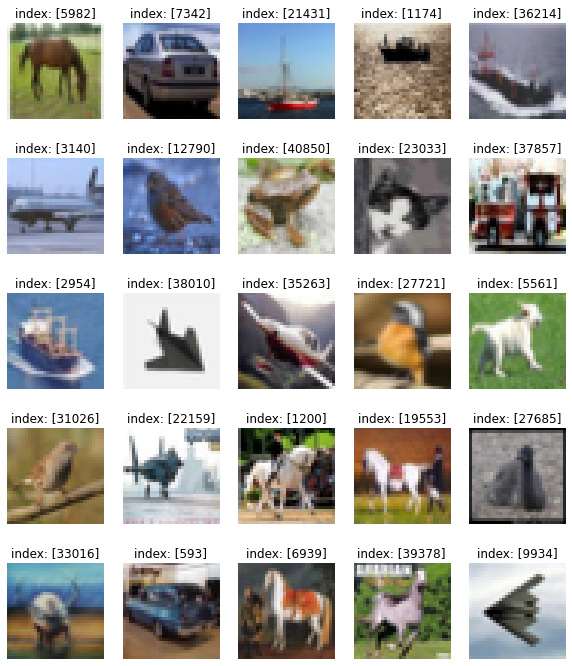

In [14]:
def clipping_img(x): 
    return (x+1)/2

plt.figure(figsize=(10, 12))

for i in range(25):
    # [[YOUR CODE]]
    img=np.random.choice(50000,1, replace=False)
    plt.subplot(5, 5, i+1)
    plt.imshow(clipping_img(train_x[img].reshape(32,32,3)))
    plt.title(f'index: {img}')
    plt.axis('off')

plt.show()

In [15]:
BUFFER_SIZE = 60000 # 데이터 사이즈와 동일하거나 크면 됨.
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [16]:
print(train_dataset.element_spec) # 데이터를 BATCH_SIZE만큼 나눔.
print(BUFFER_SIZE/BATCH_SIZE) # 1 에포크 돌릴때 234.375 step

TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None)
234.375


In [17]:
save_every = 10
EPOCHS = 200

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 3. 모델학습하기
### 3-1. 기본 모델(try1) 및 개선방안
- 데이터 cifar-10 전체, batch size: 256, epoch: 200
- 생성자(make_generator_model_ver3 / batch normalization 사용/ conv layer 3층)
- LeakyReLu: 0.3, 처음 filter 개수: 256, 커널사이즈: (5,5))
- 판별자(make_discriminator_model_ver1, LeakyReLu: 0.3, 처음 filter 개수: 256))

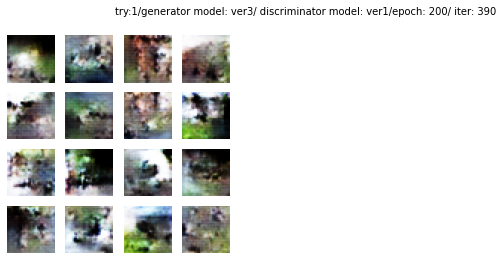

Time for training : 3220 sec


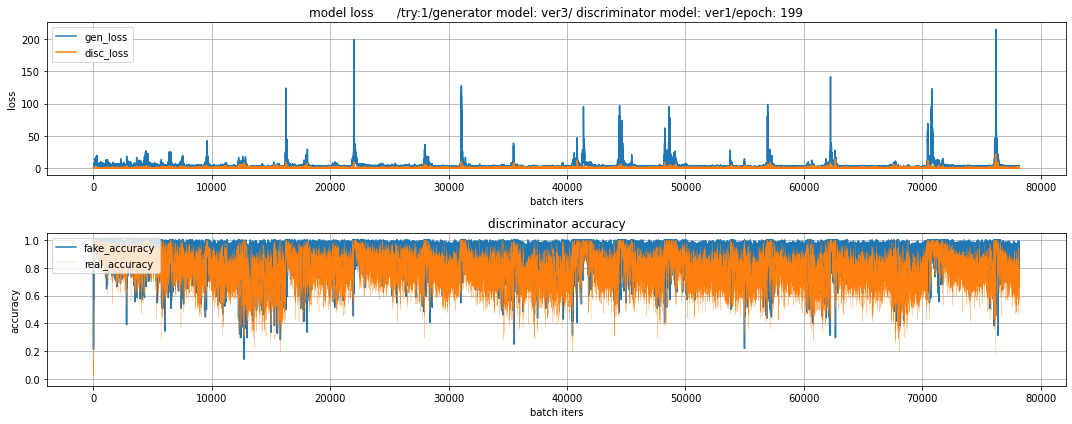

In [78]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim], mean=0.0, stddev=1.0,)


lr, beta_1=10e-4, 0.9 # Adam의 beta_1은 0.9가 기본값
try_=1
gener_ver=3; gener_filter_num=256; gener_leaky_alpha=0.3; gener_kernel_size=5
disc_ver1=True; disc_filter_num=256; disc_leaky_alpha=0.3

# 폴더 생성
#os.mkdir(os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try{}'.format(try_)) 
#os.mkdir(os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try{}/training_checkpoints'.format(try_)) 
#os.mkdir(os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try{}/generated_samples'.format(try_))
#os.mkdir(os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try{}/training_history'.format(try_))

generator,discriminator=select_model_ver(gener_ver, disc_ver1, 
                                         gener_filter_num, gener_leaky_alpha, gener_kernel_size,
                                         disc_filter_num, disc_leaky_alpha)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr,beta_1=beta_1)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr,beta_1=beta_1)

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try{}/training_checkpoints'.format(try_)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint 저장
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

%time
history=train(train_dataset, EPOCHS, save_every, try_=try_,
              gener_ver=gener_ver,gener_filter_num=gener_filter_num, gener_leaky_alpha=gener_leaky_alpha, gener_kernel_size=gener_kernel_size,
              disc_ver1=disc_ver1, disc_filter_num=disc_filter_num, disc_leaky_alpha=disc_leaky_alpha)

- fake accuracy가 전혀 줄어들지 않고, 아래의 latent vector로부터 생성된 이미지도 cifar-10에서 보았던 이미지와 비슷하다고 보긴 힘들어서 fake image를 제대로 만들어내고 있지 못한 것을 알수 있다.

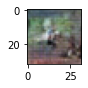

In [79]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try{}/training_checkpoints'.format(try_)

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)

plt.figure(figsize=(1,1))
plt.imshow(np_generated[0])
plt.show()  # 이미지는 생성되지만 cifar-10의 이미지라고는 보기 힘들다.

### - 모델 개선방안
1. batch size를 125로 줄이고
2. [Tips for Training Stable Generative Adversarial Networks](https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/)의 조언에 따라 Adam의 learning rate는 0.0002, beta_1는 0.5로 고친다. 또한 LeakyReLu의 alpha값을 0.2로 줄여본다.(기본값은 0.3이었음)
3. __5조의 강태원님__ 의 조언에 따라 생성자의 convolution 레이어를 더 쌓아보자, batch normalization은 그대로 써보자. 
4. 생성자의 커널사이즈가 기본 모델에서는 5,5였다. 생각해보면 이미지 사이즈가 (32,32) 이므로 상대적으로 커널사이즈가 크다고 생각이 되어서 일단 하나 작은 사이즈인 4,4로 돌려보기로 했다. 또한 convolution 레이어의 처음 filter의 개수(depth)를 2배 늘려보자.

5. 판별자의 마지막 레이어에 sigmoid 활성화 함수를 추가해보자(make_discriminator_model_ver2 사용)


### 3-2. 개선시킨 모델 : (try2)
- epoch: 200
- 데이터 cifar-10 전체, batch size: 128
- 생성자(make_generator_model_ver1, batch normaliization 있음, conv layer 4층)
: LeakyReLu: 0.2, 처음 filter 개수(depth): 512, 커널사이즈: (4,4), batch normalization 사용)
- 판별자(make_discriminator_model_ver2,sigmoid 함수 사용, LeakyReLu: 0.2, 처음 filter 개수: 256)), 
- Adam: lr=0.0002, beta_1: 0.5


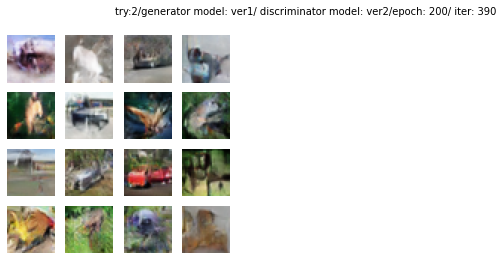

Time for training : 5931 sec


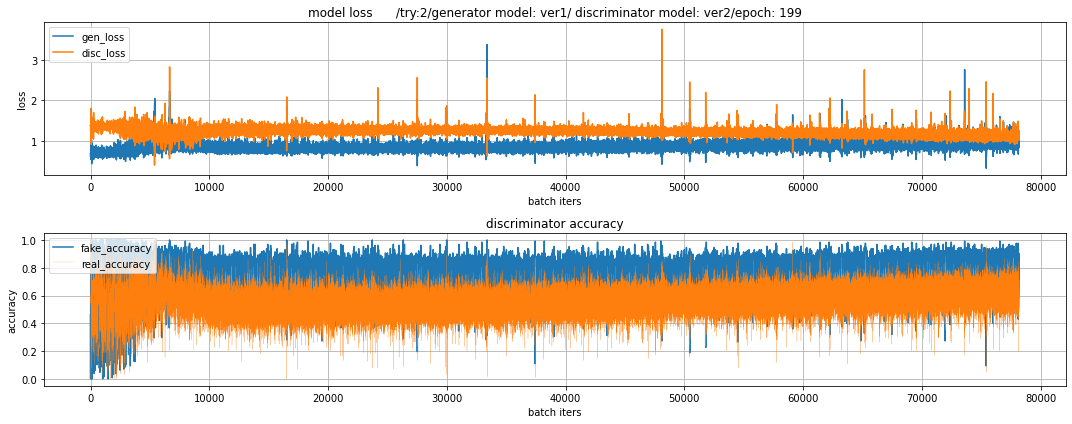

In [81]:
BUFFER_SIZE = 50000 # 데이터 사이즈와 동일하거나 크면 됨.
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
save_every = 10

EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim], seed=3)

lr, beta_1=0.0002, 0.5
try_=2
gener_ver=1; gener_filter_num=512; gener_leaky_alpha=0.2; gener_kernel_size=4
disc_ver1=False; disc_filter_num=512; disc_leaky_alpha=0.2

# 폴더 생성
os.mkdir(os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try{}'.format(try_)) 
os.mkdir(os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try{}/training_checkpoints'.format(try_)) 
os.mkdir(os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try{}/generated_samples'.format(try_))
os.mkdir(os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try{}/training_history'.format(try_))

generator,discriminator=select_model_ver(gener_ver, disc_ver1, 
                                         gener_filter_num, gener_leaky_alpha, gener_kernel_size,
                                         disc_filter_num, disc_leaky_alpha)


generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr,beta_1=beta_1)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr,beta_1=beta_1)

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try{}/training_checkpoints'.format(try_)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint 저장
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#%%time
history=train(train_dataset, EPOCHS, save_every, try_=try_,
              gener_ver=gener_ver,gener_filter_num=gener_filter_num, gener_leaky_alpha=gener_leaky_alpha, gener_kernel_size=gener_kernel_size,
              disc_ver1=disc_ver1, disc_filter_num=disc_filter_num, disc_leaky_alpha=disc_leaky_alpha)

 try1의 fake accuracy가 거의 1에서 꿈쩍도 안한 것에 비해 fake accuracy가 하강곡선을 그리고 있는 것을 확인 할수 있다. 이미지에 고양이 비슷한 것과 배 비슷한 것이 나타난 것으로 보아서 기본 모델의 GAN을 개선한 것으로 보인다. 

GIF만들기

In [82]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try{}/cifar10_dcgan_try{}.gif'.format(try_,try_)

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/try{}/generated_samples/sample*.png'.format(os.getenv('HOME'),try_))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [84]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try2/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator
# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 


아래와 같은 방법을 추가하여서 학습된 생성자 모델을 통해서 또 다른 latent 벡터를 입력하니가 말 비슷하게 생긴 이미지가 생성된 것을 확인할수 있었다.

### 루브릭1. 에서 요구한 육안으로 구분 가능한 객체(말)이 생성되었고, 좀 더 많은 이미지를 만들어보기 위해서 아래와 같이 64개의 이미지를 만들어보았다.

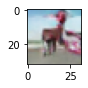

In [129]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.figure(figsize=(1,1))
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

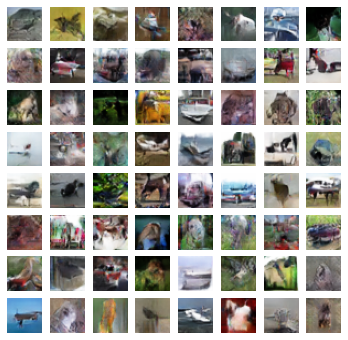

In [134]:
noise = tf.random.normal([64, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)

plt.figure(figsize=(6,6))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(np_generated[i, :, :, :])
    plt.axis('off')

plt.show()

- 더 많은 임의의 벡터를 입력해서 확인해보았다. 기본모델(try1)에 비해서 말과 비슷한 객체, 배같이 생긴 것도 보이고, 자동차 비슷한 것도 보인다. 비행기 앞쪽 같이 생긴 것도 언듯 보인다.
- GIF 파일을 아래와 같이 생성했다. __(루브릭 2)__
![](https://github.com/Asunny2019/AIFFEL_Exploration/blob/main/img/cifar10_dcgan_try2%20(1).gif?raw=true)

### 모델을 학습하는 과정에서 여러가지 궁금한 것이 생겼다. 
 1. latent 벡터를 생성자가 처음 만들었을때는 그냥 노이즈에 불과했다가 각 샘플들이 점차 이미지의 __특징(feature)__ 들이 생겨나는 것을 확인했다. 어떤 샘플은 좀 일찍 이미지가 생겨나고, 어떤 샘플은 에포크가 200에 가까워져서 생겨나는등 차이가 있어서 혹시 latent 벡터를 스케일링을 하면 고르게 이미지가 생겨날까 궁금증이 생겼다. 
 2. 전체 이미지가 아니라. 몇가지 이미지만 묶어서 학습을 시켜보고 싶었다. 
 >a. 텍스쳐가 비슷한 이미지(개&고양이)   
 >b. 멀리서 보면 모양이 비슷한 이미지(새, 비행기)   

3. batch normalization을 빼거나 판별자(discriminator)를 제외하고 돌렸을때 어떤 결과가 날지 궁금했다.

### 3-3. 개선모델(try2)+ latent 벡터의 랜덤 값을 -1 ~ 1 사이로 조정:  (try3)

- try2와 다른 것은 모두 동일한데 seed, 즉, latent vector를 normal distribution을 스케일링 해보자. 훈련데이터와 마찬가지로 [ -1 , 1 ]사이에 오도록 Max Abs 정규화를 해보자

In [41]:
BUFFER_SIZE = 50000 # 데이터 사이즈와 동일하거나 크면 됨.
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
save_every = 10
EPOCHS = 200

In [20]:
seed_1 = tf.random.normal([num_examples_to_generate, noise_dim], seed=3)
max_abs=np.max(np.absolute(seed_1.numpy()))
seed=seed_1/max_abs

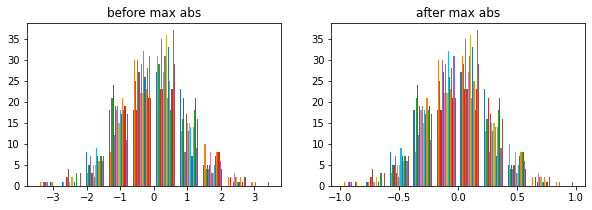

In [24]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.hist(seed_1)# latent vector가 -1과 1 범위 안에 들어감!
plt.title("before max abs")

plt.subplot(1,2,2)
plt.hist(seed)# latent vector가 -1과 1 범위 안에 들어감!
plt.title("after max abs")
plt.show()

- 원래 latent vector는 -3 ~ 3사이(평균0, 표준편차1)이었는데, 오른쪽 이미지처럼 -1 ~ 1로 스케일링을 했다.

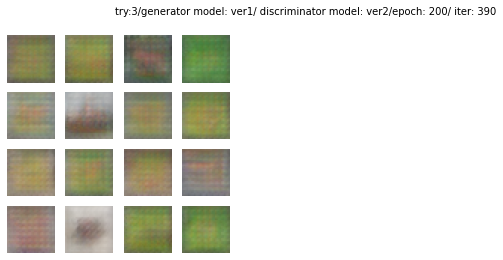

Time for training : 5604 sec


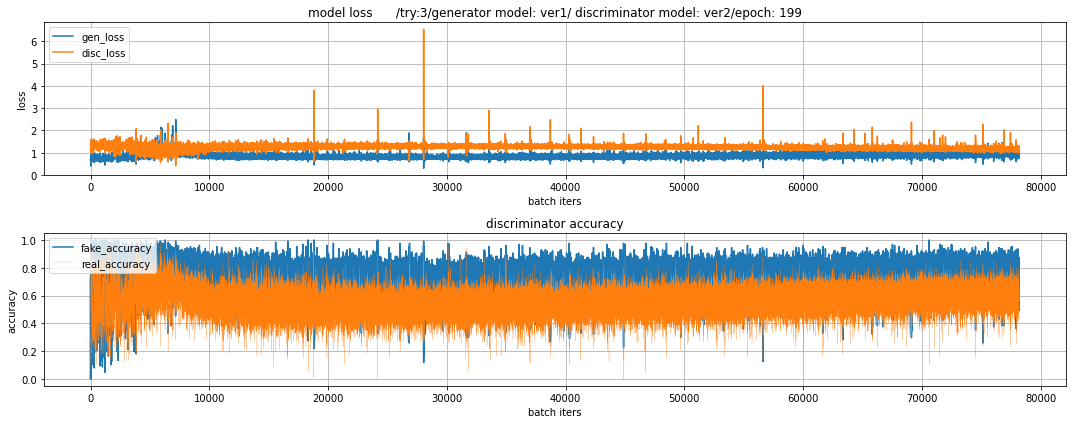

In [42]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim], seed=3)
max_abs=np.max(np.absolute(seed.numpy()))
seed=seed/max_abs
lr, beta_1=0.0002, 0.5
try_=3
gener_ver=1; gener_filter_num=512; gener_leaky_alpha=0.2; gener_kernel_size=4
disc_ver1=False; disc_filter_num=512; disc_leaky_alpha=0.2

# 폴더 생성
#make_folder(try_)

generator,discriminator=select_model_ver(gener_ver, disc_ver1, 
                                         gener_filter_num, gener_leaky_alpha, gener_kernel_size,
                                         disc_filter_num, disc_leaky_alpha)


generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr,beta_1=beta_1)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr,beta_1=beta_1)

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try{}/training_checkpoints'.format(try_)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint 저장
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#%%time
history=train(train_dataset, EPOCHS, save_every, try_=try_,
              gener_ver=gener_ver,gener_filter_num=gener_filter_num, gener_leaky_alpha=gener_leaky_alpha, gener_kernel_size=gener_kernel_size,
              disc_ver1=disc_ver1, disc_filter_num=disc_filter_num, disc_leaky_alpha=disc_leaky_alpha)

fake accuracy 는 try2와 같이 낮아졌지만 이상하게 이미지는 생성이 잘 안된다. 혹시하는 마음에 -1~1로 스케일링 한 latent 벡터와 스케일링을 하지 않은 latent 벡터를 모델에 넣고 이미지를 넣고 각각 다시 생성해보았다.   

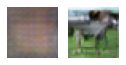

In [178]:
noise,noise1 = tf.random.normal([1, 100]),tf.random.normal([1, 100])
max_abs=np.max(np.absolute(noise.numpy()))
noise=noise/max_abs

generated_image = generator(noise, training=False)
generated_image1 = generator(noise1, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)

np_generated1 = generated_image1.numpy()
np_generated1 = (np_generated1 * 127.5) + 127.5   # reverse of normalization
np_generated1 = np_generated1.astype(int)

plt.figure(figsize=(2,4))
plt.subplot(1,2,1)
plt.imshow(np_generated[0])
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(np_generated1[0])

plt.axis("off")
plt.show()  

이미지가 생성이 스케일을 -1 ~ 1 사이로 제한을 한 노이즈를 latent 벡터로 넣었을때는 이미지가 잘 생성이 안되었다. 그러나 latent 벡터를 스케일링을 하지 않은 정규분포를 따르는 랜덤 값을 입력하니까 흐릿하지만 말의 몸통과 다리가 보인다. GAN으로 이미지를 생성할때 latent 벡터의 분포를 고를때 신중할 필요가 있다.

### 3-4. 개선모델(try2)에서 Batch Normalize를 빼보자 : (try4)

- try2와 다른 것은 모두 동일한데 생성자의 Batch Normalize를 제외하면 어떨까 궁금했다. 일반적으로 다양한 네트워크의 Regularize를  제외하고 돌려보도록 하자(make_generator_model_ver2)

In [195]:
BUFFER_SIZE = 50000 # 데이터 사이즈와 동일하거나 크면 됨.
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
save_every = 10
EPOCHS = 200

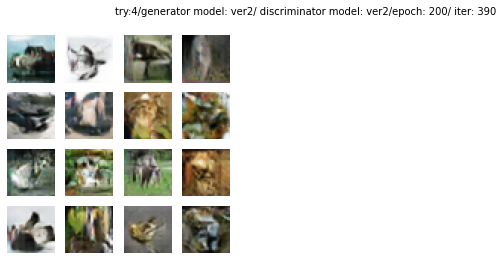

Time for training : 5379 sec


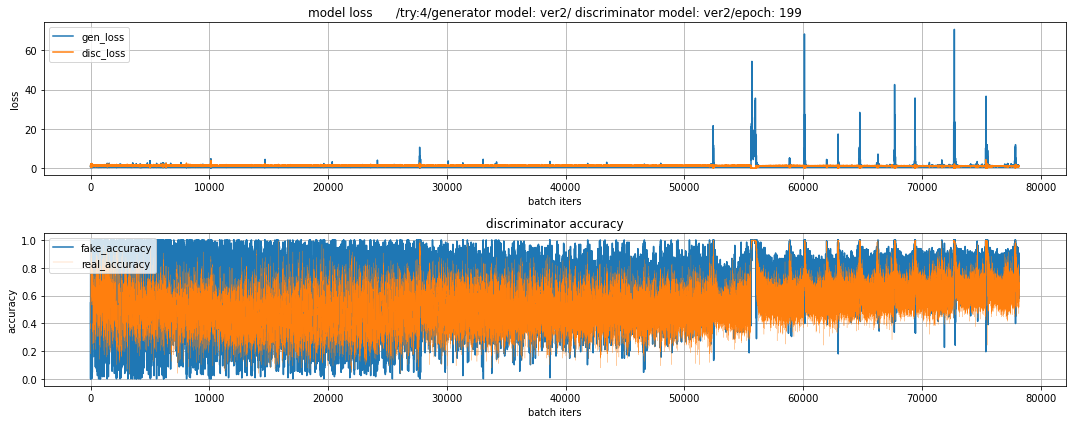

In [201]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim], seed=3)

lr, beta_1=0.0002, 0.5
try_=4
gener_ver=2; gener_filter_num=512; gener_leaky_alpha=0.2; gener_kernel_size=4
disc_ver1=False; disc_filter_num=512; disc_leaky_alpha=0.2

# 폴더 생성
make_folder(try_)

generator,discriminator=select_model_ver(gener_ver, disc_ver1, 
                                         gener_filter_num, gener_leaky_alpha, gener_kernel_size,
                                         disc_filter_num, disc_leaky_alpha)


generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr,beta_1=beta_1)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr,beta_1=beta_1)

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try{}/training_checkpoints'.format(try_)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint 저장
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#%%time
history=train(train_dataset, EPOCHS, save_every, try_=try_,
              gener_ver=gener_ver,gener_filter_num=gener_filter_num, gener_leaky_alpha=gener_leaky_alpha, gener_kernel_size=gener_kernel_size,
              disc_ver1=disc_ver1, disc_filter_num=disc_filter_num, disc_leaky_alpha=disc_leaky_alpha)

In [204]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try{}/training_checkpoints'.format(try_)

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

In [223]:
latest

'/aiffel/aiffel/dcgan_newimage/cifar10/try4/training_checkpoints/ckpt-20'

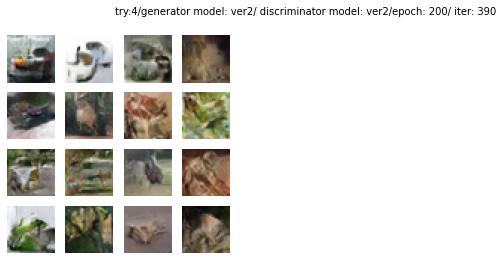

Time for training : 5328 sec


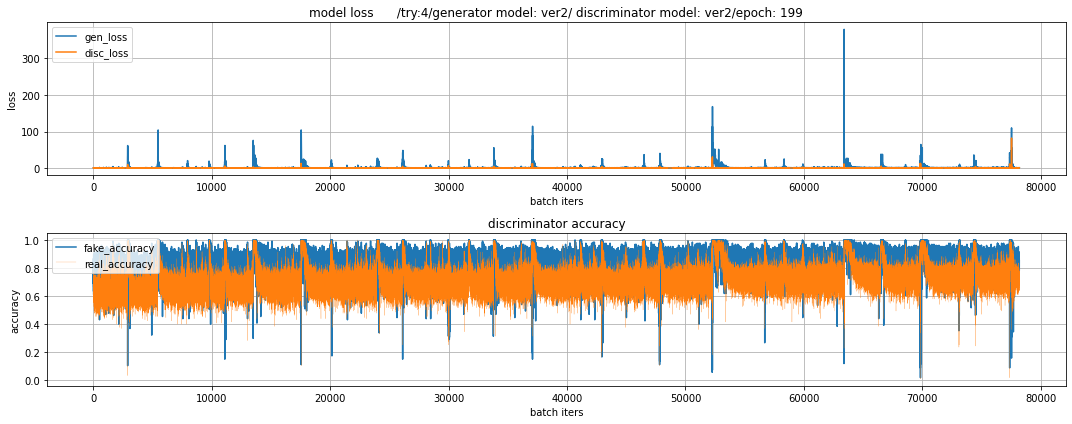

In [224]:
EPOCHS=200
history=train(train_dataset, EPOCHS, save_every, try_=try_,
              gener_ver=gener_ver,gener_filter_num=gener_filter_num, gener_leaky_alpha=gener_leaky_alpha, gener_kernel_size=gener_kernel_size,
              disc_ver1=disc_ver1, disc_filter_num=disc_filter_num, disc_leaky_alpha=disc_leaky_alpha)

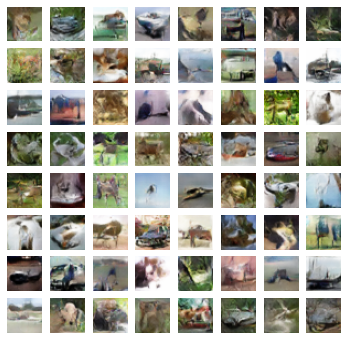

In [225]:
noise = tf.random.normal([64, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)

plt.figure(figsize=(6,6))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(np_generated[i, :, :, :])
    plt.axis('off')

plt.show()

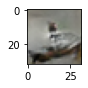

In [226]:
# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.figure(figsize=(1,1))
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

### 3-5. 개와 고양이 이미지만 모아서 개선된 GAN 모델(try2)을 돌려보자! :(try5)

- 고양이와 강아지 이미지만 모아서 모델을 만들어보자    
- 작고 온몸에 털이 많은 (비슷한 텍스쳐)를 가진 동물의 이미지를 잘 구분해내고 이미지를 잘 만들어낼수 있을까? 궁금해서 이미지를 학습해보았다.
- 이미지 라벨의 번호  
0번: airplane / 1번: automobile	/ 2번: bird	/ 3번: cat/ 4번: deer	/5번: dog/ 6번: frog	/ 7번: horse/ 8번: ship/ 9번 : truck

In [22]:
cifar10 = tf.keras.datasets.cifar10

# GAN학습을 할때는 label(정답)은 필요가 없다.
(train_x, train_y), (test_x, test_y) = cifar10.load_data()

train_x.shape

for i in range(10):
    print("label %d:"%i,train_y[train_y==i].shape[0], end=" /")



label 0: 5000 /label 1: 5000 /label 2: 5000 /label 3: 5000 /label 4: 5000 /label 5: 5000 /label 6: 5000 /label 7: 5000 /label 8: 5000 /label 9: 5000 /

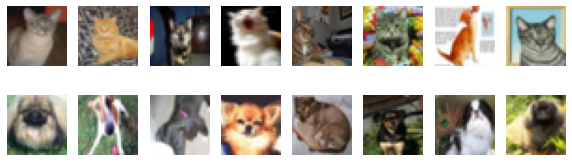

max pixel: 255
min pixel: 0
정규화 후 max pixel: 1.0
정규화 후 min pixel: -1.0
TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float64, name=None)


In [23]:
idx3=[i for i,label in enumerate(train_y) if label==3]
idx5=[i for i,label in enumerate(train_y) if label==5]
train_x3=train_x[idx3]
train_x5=train_x[idx5]

plt.figure(figsize=(10,3))
for i in range(8):
    idx=np.random.choice(5000)
    plt.subplot(2,8,i+1)
    plt.imshow(train_x3[idx])
    plt.axis("off")
for i in range(8,16):
    idx=np.random.choice(5000)
    plt.subplot(2,8,i+1)
    plt.imshow(train_x5[idx])
    plt.axis("off")

plt.show()

train_x=np.concatenate((train_x3, train_x5),axis=0)

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

# 이미지를 [-1, 1]로 정규화합니다.
train_x = (train_x - 127.5) / 127.5 

print("정규화 후 max pixel:", train_x.max())
print("정규화 후 min pixel:", train_x.min())

BUFFER_SIZE = 50000 # 데이터 사이즈와 동일하거나 크면 됨.
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# batch: 데이터를 BATCH_SIZE(=256)만큼 나눈다
print(train_dataset.element_spec)

개와 고양이로만 이루어진 데이터셋으로 학습을 시켜보자. 고양이 5000장, 개 5000장으로 학습시킨다.

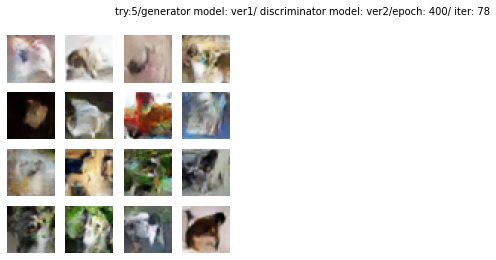

Time for training : 2937 sec


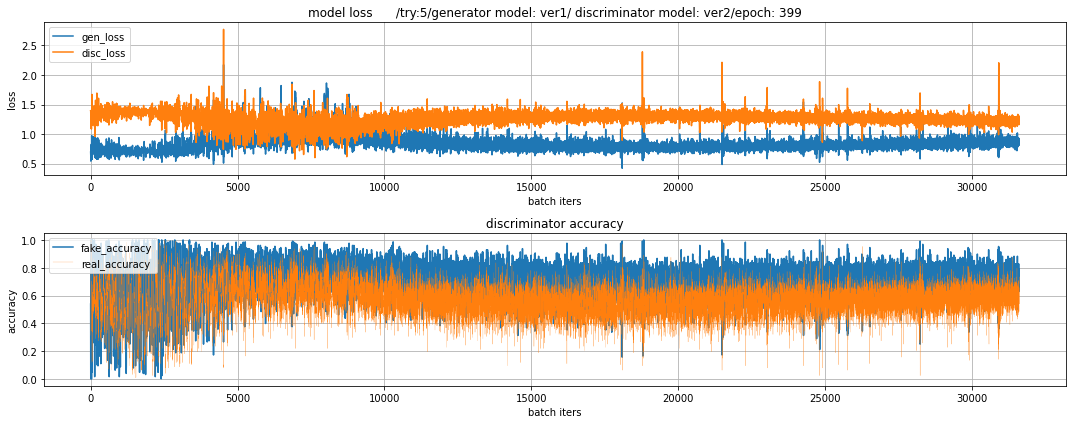

In [24]:
save_every = 10

EPOCHS = 400
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim], seed=3)

lr, beta_1=0.0002, 0.5
try_=5
gener_ver=1; gener_filter_num=512; gener_leaky_alpha=0.2; gener_kernel_size=4
disc_ver1=False; disc_filter_num=512; disc_leaky_alpha=0.2


# 폴더 생성
#make_folder(try_)

generator,discriminator=select_model_ver(gener_ver, disc_ver1, 
                                         gener_filter_num, gener_leaky_alpha, gener_kernel_size,
                                         disc_filter_num, disc_leaky_alpha)


generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr,beta_1=beta_1)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr,beta_1=beta_1)

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try{}/training_checkpoints'.format(try_)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint 저장
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#%%time
history=train(train_dataset, EPOCHS, save_every, try_=try_,
              gener_ver=gener_ver,gener_filter_num=gener_filter_num, gener_leaky_alpha=gener_leaky_alpha, gener_kernel_size=gener_kernel_size,
              disc_ver1=disc_ver1, disc_filter_num=disc_filter_num, disc_leaky_alpha=disc_leaky_alpha)

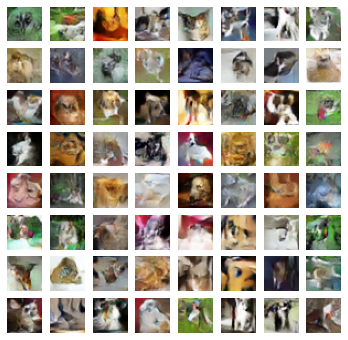

In [25]:
noise = tf.random.normal([64, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)

plt.figure(figsize=(6,6))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(np_generated[i, :, :, :])
    plt.axis('off')

plt.show()

개와 고양이 이미지가 생성된 것을 확인했다

In [26]:
try_=5
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try{}/cifar10_dcgan_try{}.gif'.format(try_,try_)

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/try{}/generated_samples/sample*.png'.format(os.getenv('HOME'),try_))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

![](https://github.com/Asunny2019/AIFFEL_Exploration/blob/main/img/cifar10_dcgan_try5.gif?raw=true)

### 3-6. 새와 비행기 이미지만 모아서 개선된 GAN 모델(try2)을 돌려보자!  :   (try6)

- 새와 비행기 이미지만 모아서 모델을 만들어보자    
- 이미지 라벨의 번호  
0번: airplane / 1번: automobile	/ 2번: bird	/ 3번: cat/ 4번: deer	/5번: dog/ 6번: frog	/ 7번: horse/ 8번: ship/ 9번 : truck

In [15]:
cifar10 = tf.keras.datasets.cifar10

# GAN학습을 할때는 label(정답)은 필요가 없다.
(train_x, train_y), (test_x, test_y) = cifar10.load_data()

train_x.shape

for i in range(10):
    print("label %d:"%i,train_y[train_y==i].shape[0], end=" /")



label 0: 5000 /label 1: 5000 /label 2: 5000 /label 3: 5000 /label 4: 5000 /label 5: 5000 /label 6: 5000 /label 7: 5000 /label 8: 5000 /label 9: 5000 /

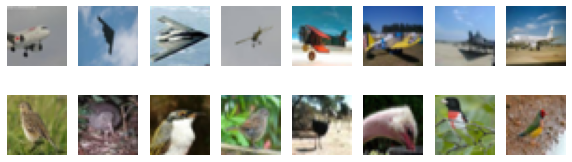

max pixel: 255
min pixel: 0
정규화 후 max pixel: 1.0
정규화 후 min pixel: -1.0
TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float64, name=None)


In [16]:
idx3=[i for i,label in enumerate(train_y) if label==0]
idx5=[i for i,label in enumerate(train_y) if label==2]
train_x3=train_x[idx3]
train_x5=train_x[idx5]

plt.figure(figsize=(10,3))
for i in range(8):
    idx=np.random.choice(5000)
    plt.subplot(2,8,i+1)
    plt.imshow(train_x3[idx])
    plt.axis("off")
for i in range(8,16):
    idx=np.random.choice(5000)
    plt.subplot(2,8,i+1)
    plt.imshow(train_x5[idx])
    plt.axis("off")

plt.show()

train_x=np.concatenate((train_x3, train_x5),axis=0)

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

# 이미지를 [-1, 1]로 정규화합니다.
train_x = (train_x - 127.5) / 127.5 

print("정규화 후 max pixel:", train_x.max())
print("정규화 후 min pixel:", train_x.min())

BUFFER_SIZE = 50000 # 데이터 사이즈와 동일하거나 크면 됨.
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# batch: 데이터를 BATCH_SIZE(=256)만큼 나눈다
print(train_dataset.element_spec)

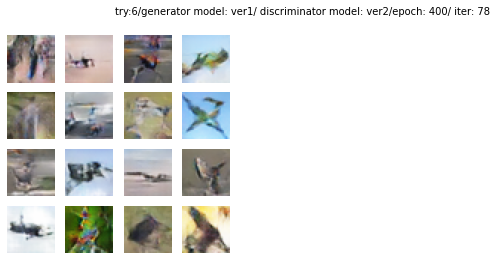

Time for training : 2933 sec


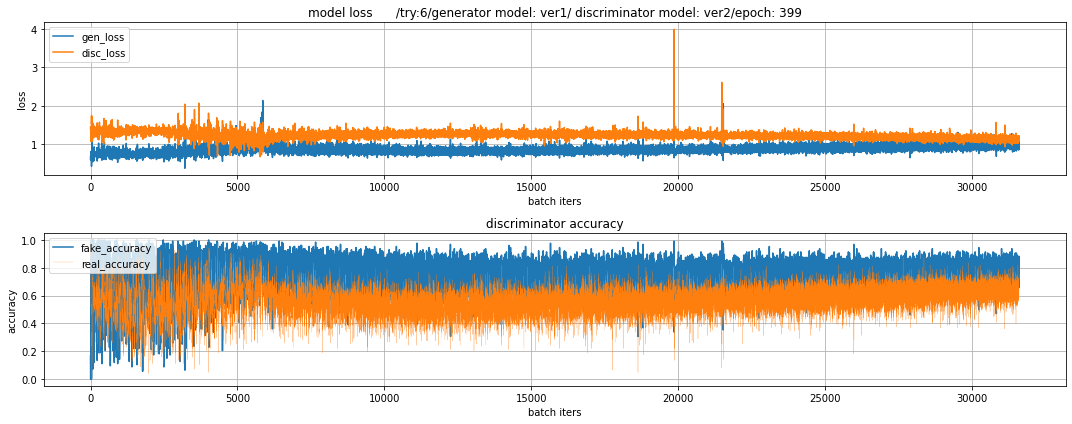

In [17]:

save_every = 10

EPOCHS = 400
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim], seed=3)

lr, beta_1=0.0002, 0.5
try_=6
gener_ver=1; gener_filter_num=512; gener_leaky_alpha=0.2; gener_kernel_size=4
disc_ver1=False; disc_filter_num=512; disc_leaky_alpha=0.2


# 폴더 생성
#make_folder(try_)

generator,discriminator=select_model_ver(gener_ver, disc_ver1, 
                                         gener_filter_num, gener_leaky_alpha, gener_kernel_size,
                                         disc_filter_num, disc_leaky_alpha)


generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr,beta_1=beta_1)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr,beta_1=beta_1)

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try{}/training_checkpoints'.format(try_)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint 저장
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#%%time
history=train(train_dataset, EPOCHS, save_every, try_=try_,
              gener_ver=gener_ver,gener_filter_num=gener_filter_num, gener_leaky_alpha=gener_leaky_alpha, gener_kernel_size=gener_kernel_size,
              disc_ver1=disc_ver1, disc_filter_num=disc_filter_num, disc_leaky_alpha=disc_leaky_alpha)

In [18]:
try_=6
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try{}/training_checkpoints'.format(try_)

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator


In [19]:
latest

'/aiffel/aiffel/dcgan_newimage/cifar10/try6/training_checkpoints/ckpt-40'

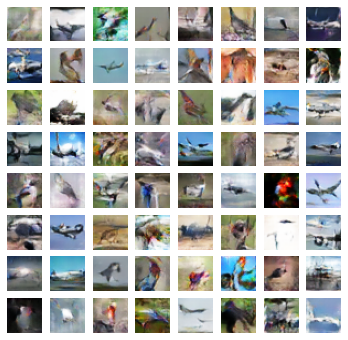

In [22]:
noise = tf.random.normal([64, 100], seed=45)
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)

plt.figure(figsize=(6,6))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(np_generated[i, :, :, :])
    plt.axis('off')

plt.show()

In [21]:
try_=6
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try{}/cifar10_dcgan_try{}.gif'.format(try_,try_)

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/try{}/generated_samples/sample*.png'.format(os.getenv('HOME'),try_))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

![](https://github.com/Asunny2019/AIFFEL_Exploration/blob/main/img/cifar10_dcgan_try6.gif?raw=true)

### 3-7. 개선된 모델의 생성자에 batch normalization 제거하고, conv 3층 : (try7)
- 성능이 좋지 않을 것이 예측이 되지만, generator를 만들때 batch normalization을 넣고 빼고, conv 레이어를 넣고 빼고 했을때 생성되는 이미지의 차이를 보고 싶어서 이 모델을 학습시켜본다.
- epoch: 200
- 데이터 cifar-10 전체, batch size: 128
- 생성자(make_generator_model_ver4/ batch normalization 없음/conv layer 3층)
: LeakyReLu: 0.2, 처음 filter 개수(depth): 512, 커널사이즈: (4,4),
- 판별자(make_discriminator_model_ver2,sigmoid 함수 사용, LeakyReLu: 0.2, 처음 filter 개수: 256)), 
- Adam: lr=0.0002, beta_1: 0.5


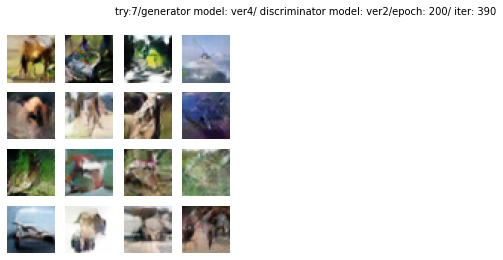

Time for training : 5407 sec


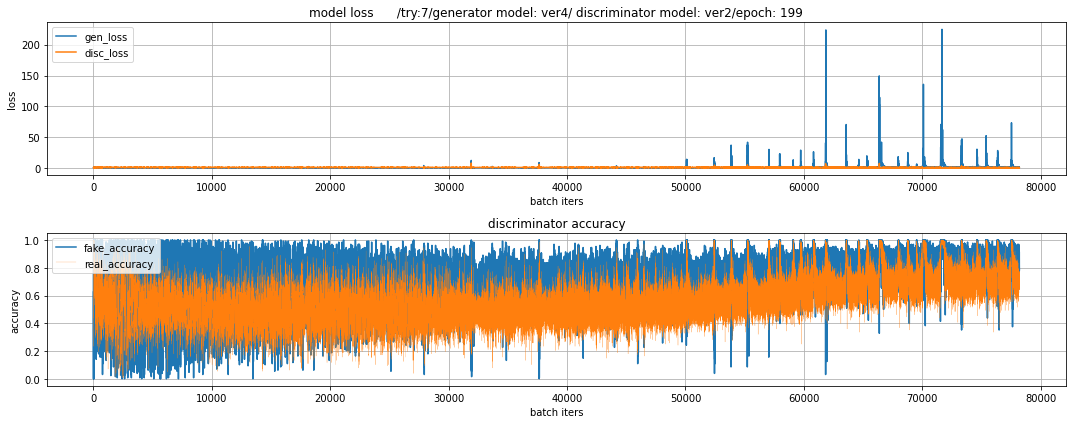

In [19]:
cifar10=tf.keras.datasets.cifar10

# GAN학습을 할때는 label(정답)은 필요가 없지만, 나중에 클래스 별로 나눠서GAN을 만들고 싶어서 시도해본다.
(train_x,train_y), (test_x,test_y) = cifar10.load_data()
train_x = (train_x - 127.5) / 127.5 
train_x = train_x.reshape(train_x.shape[0], 32,32, 3).astype('float32')

BUFFER_SIZE = 50000 # 데이터 사이즈와 동일하거나 크면 됨.
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
save_every = 10

EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim], seed=3)

lr, beta_1=0.0002, 0.5
try_=7
gener_ver=4; gener_filter_num=512; gener_leaky_alpha=0.2; gener_kernel_size=4
disc_ver1=False; disc_filter_num=512; disc_leaky_alpha=0.2

# 폴더 생성
#os.mkdir(os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try{}'.format(try_)) 
#os.mkdir(os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try{}/training_checkpoints'.format(try_)) 
#os.mkdir(os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try{}/generated_samples'.format(try_))
#os.mkdir(os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try{}/training_history'.format(try_))

generator,discriminator=select_model_ver(gener_ver, disc_ver1, 
                                         gener_filter_num, gener_leaky_alpha, gener_kernel_size,
                                         disc_filter_num, disc_leaky_alpha)


generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr,beta_1=beta_1)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr,beta_1=beta_1)

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try{}/training_checkpoints'.format(try_)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint 저장
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#%%time
history=train(train_dataset, EPOCHS, save_every, try_=try_,
              gener_ver=gener_ver,gener_filter_num=gener_filter_num, gener_leaky_alpha=gener_leaky_alpha, gener_kernel_size=gener_kernel_size,
              disc_ver1=disc_ver1, disc_filter_num=disc_filter_num, disc_leaky_alpha=disc_leaky_alpha)

GIF만들기

In [20]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try{}/cifar10_dcgan_try{}.gif'.format(try_,try_)

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/try{}/generated_samples/sample*.png'.format(os.getenv('HOME'),try_))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [21]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try7/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator
# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 


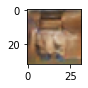

In [22]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.figure(figsize=(1,1))
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

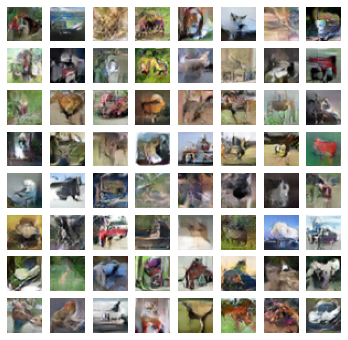

In [23]:
noise = tf.random.normal([64, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)

plt.figure(figsize=(6,6))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(np_generated[i, :, :, :])
    plt.axis('off')

plt.show()

### 3-8.  개선모델(try2)의 판별자를 sigmoid가 없는 것으로  바꿈: (try8)
- epoch: 200
- 데이터 cifar-10 전체, batch size: 128
- 생성자(make_generator_model_ver1/ batch normalization 있음/conv layer 4층)
: LeakyReLu: 0.2, 처음 filter 개수(depth): 512, 커널사이즈: (4,4),
- 판별자(make_discriminator_model_ver1,이진계단함수 사용, LeakyReLu: 0.2, 처음 filter 개수: 256)), 
- Adam: lr=0.0002, beta_1: 0.5


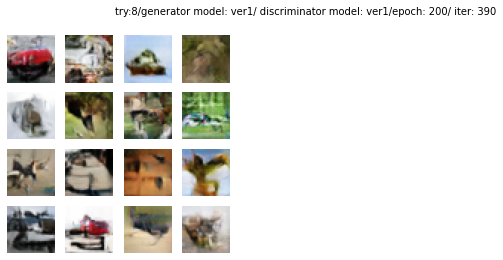

Time for training : 5859 sec


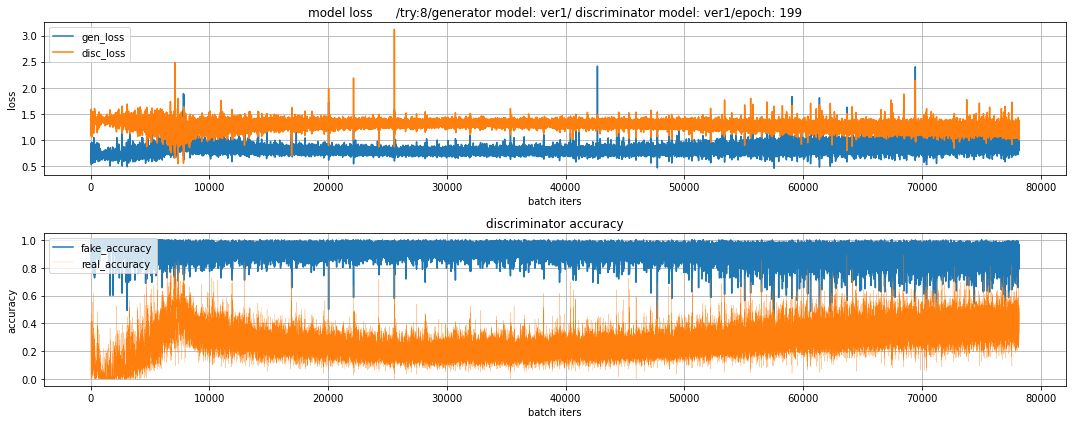

In [28]:
cifar10=tf.keras.datasets.cifar10

# GAN학습을 할때는 label(정답)은 필요가 없지만, 나중에 클래스 별로 나눠서GAN을 만들고 싶어서 시도해본다.
(train_x,train_y), (test_x,test_y) = cifar10.load_data()
train_x = (train_x - 127.5) / 127.5 
train_x = train_x.reshape(train_x.shape[0], 32,32, 3).astype('float32')

BUFFER_SIZE = 50000 # 데이터 사이즈와 동일하거나 크면 됨.
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
save_every = 10

EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim], seed=3)

lr, beta_1=0.0002, 0.5
try_=8
gener_ver=1; gener_filter_num=512; gener_leaky_alpha=0.2; gener_kernel_size=4
disc_ver1=True; disc_filter_num=512; disc_leaky_alpha=0.2

# 폴더 생성
#make_folder(try_)
generator,discriminator=select_model_ver(gener_ver, disc_ver1, 
                                         gener_filter_num, gener_leaky_alpha, gener_kernel_size,
                                         disc_filter_num, disc_leaky_alpha)


generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr,beta_1=beta_1)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr,beta_1=beta_1)

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try{}/training_checkpoints'.format(try_)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint 저장
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#%%time
history=train(train_dataset, EPOCHS, save_every, try_=try_,
              gener_ver=gener_ver,gener_filter_num=gener_filter_num, gener_leaky_alpha=gener_leaky_alpha, gener_kernel_size=gener_kernel_size,
              disc_ver1=disc_ver1, disc_filter_num=disc_filter_num, disc_leaky_alpha=disc_leaky_alpha)

GIF만들기

In [29]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try{}/cifar10_dcgan_try{}.gif'.format(try_,try_)

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/try{}/generated_samples/sample*.png'.format(os.getenv('HOME'),try_))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [30]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/try8/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator
# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 


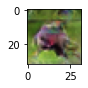

In [55]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.figure(figsize=(1,1))
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

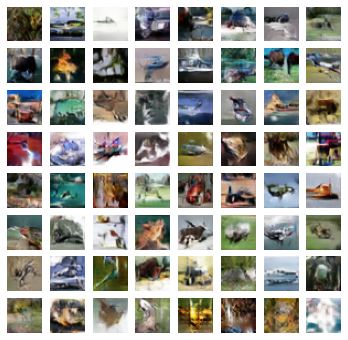

In [58]:
noise = tf.random.normal([64, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)

plt.figure(figsize=(6,6))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(np_generated[i, :, :, :])
    plt.axis('off')

plt.show()

## 4.관찰